In [1]:
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [0]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

In [0]:
class gan_config:
    def __init__(self,name,optimizer,):   
        self.name = name
        self.generate_real_samples = generate_real_samples
        self.generate_latent_points = generate_latent_points   
        self.n_epochs = n_epochs   
        self.n_eval = n_eval   
        self.latent_dim = latent_dim
        self.n_inputs = n_inputs
        self.is_3d = is_3d
        self.combined_plot = combined_plot

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
def draw_tsne(reals,fakes,ax_todraw):
  #plt.figure()
  reals_label = np.ones((reals.shape[0],1)) 
  real_vals = np.hstack((reals,reals_label))

  fakes_label = np.zeros((fakes.shape[0],1)) 
  fake_vals = np.hstack((fakes,fakes_label))

  all_vals = np.vstack((real_vals,fake_vals))
  X_embedded = TSNE(n_components=2).fit_transform(all_vals)
  tsne_obj = X_embedded
  y = all_vals[:,-1]
  tsne_df = pd.DataFrame({'X':tsne_obj[:,0],'Y':tsne_obj[:,1],'digit':y})
  tsne_df.head()
 
  sns.scatterplot(x="X", y="Y",data=tsne_df ,hue="digit", ax=ax_todraw )

def draw_tsns4(test_result):
 
  plt.figure()
  f, axes = plt.subplots(2, 5,figsize=(18,6))
 
 

  for i in range(0,len(test_result[3])):     
    draw_tsne(test_result[3][i],test_result[4][i],axes[i//5,i % 5])
  plt.tight_layout() 
  plt.show()        

In [0]:
class TestSession():
  def __init__(self, learning_rate, name,optimizer):
    self.learning_rate = learning_rate
    self.name = name
    self.optimizer = optimizer

  def display(self):
    return  self.name +" : "+ str(self.learning_rate)  

In [0]:
class gan_gen:
    def __init__(self,name,generate_real_samples,generate_latent_points,n_epochs,n_eval,latent_dim,n_inputs,define_generator,optimizer_gan,is_3d=True,combined_plot=False,input_dim=64):   
        self.name = name
        self.generate_real_samples = generate_real_samples
        self.generate_latent_points = generate_latent_points   
        self.n_epochs = n_epochs   
        self.n_eval = n_eval   
        self.latent_dim = latent_dim
        self.n_inputs = n_inputs
        self.is_3d = is_3d
        self.combined_plot = combined_plot
        self.define_generator = define_generator
        self.input_dim = input_dim
        self.optimizer_gan = optimizer_gan
       
    # define the combined generator and discriminator model, for updating the generator
    def define_gan(self,generator, discriminator):
        # make weights in the discriminator not trainable
        discriminator.trainable = False
        # connect them
        model = Sequential()
        # add generator
        model.add(generator)
        # add the discriminator
        model.add(discriminator)
        # compile model
        model.compile(loss='binary_crossentropy', optimizer=self.optimizer_gan)
        return model
     
    # use the generator to generate n fake examples, with class labels
    def generate_fake_samples(self,generator, latent_dim, n):
      # generate points in latent space
      x_input = generate_latent_points(latent_dim, n)
      # predict outputs
      X = generator.predict(x_input)
      # create class labels
      y = zeros((n, 1))
      return X, y 
   
    def train(self,g_model, d_model, gan_model, latent_dim, n_epochs, n_eval, n_batch=64):
        print("parameters n_epochs, n_eval, n_batch ", n_epochs, n_eval, n_batch)
        # determine half the size of one batch, for updating the discriminator
        half_batch = int(n_batch / 2)
       
        #pyplot.figure(figsize=(8,4))
        #pyplot.figure(figsize=(20,20))
        counter = 0

        losses_discriminator_real = []
        losses_discriminator_fake = []
        losses_generator = []
        real_values = []
        fake_values = []
        acc_discriminator_real = []
        acc_discriminator_fake = []
        # manually enumerate epochs
        for i in range(n_epochs):
            # prepare real samples
            x_real, y_real = self.generate_real_samples(half_batch)
            # prepare fake examples
            x_fake, y_fake = self.generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator
            d_model.train_on_batch(x_real, y_real)
            d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            x_gan = self.generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            gan_model.train_on_batch(x_gan, y_gan)
            # evaluate the model every n_eval epochs
            if (i+1) % n_eval == 0:
                g_loss  = gan_model.test_on_batch(x_gan, y_gan)
                losses_generator.append(g_loss)
                #print("performance g=", i, g_loss)
                counter = counter + 1
                performance_metrics = self.summarize_performance(counter,i, g_model, d_model, latent_dim)
                losses_discriminator_real.append(performance_metrics[0] )
                losses_discriminator_fake.append(performance_metrics[1] )
                acc_discriminator_real.append(performance_metrics[4] )
                acc_discriminator_fake.append(performance_metrics[5] )
                real_values.append(performance_metrics[2] )
                fake_values.append(performance_metrics[3] )
        pyplot.show()       
        if self.combined_plot :
          self.draw_plots2d(real_values,fake_values,"x")
        else :
          self.draw_plots(real_values,"real ")
          self.draw_plots(fake_values,"fake ")
       
        return (losses_generator,losses_discriminator_real,losses_discriminator_fake,real_values,fake_values,acc_discriminator_real,acc_discriminator_fake)
               
    # evaluate the discriminator and plot real and fake points
    def summarize_performance(self,counter,epoch, generator, discriminator, latent_dim, n=200):
        #pyplot.subplot(5,5, counter)
        # prepare real samples
        x_real, y_real = self.generate_real_samples(n)
        # evaluate discriminator on real examples
        loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=1)
        # prepare fake examples
        x_fake, y_fake = self.generate_fake_samples(generator, latent_dim, n)
        # evaluate discriminator on fake examples
        loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=1)
        

        return [loss_real,loss_fake,x_real,x_fake,acc_real,acc_fake]
       
       
    def define_discriminator(self,n_inputs):
        model = Sequential()
        lrel = LeakyReLU(alpha=0.3)

        model.add(Dense(25, activation=lrel, kernel_initializer='he_uniform', input_dim=n_inputs))
        model.add(Dense(1, activation='sigmoid'))
        # compile model
        #keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=1, patience=10, verbose=1, )

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # define the standalone generator model

       
    def create(self):
        # size of the latent space
       
        # create the discriminator
        discriminator = self.define_discriminator(self.n_inputs)
        # create the generator
        generator = self.define_generator(self.latent_dim)
        # create the gan
        gan_model = self.define_gan(generator, discriminator)
        # train model
        losses = self.train(generator, discriminator, gan_model,self.latent_dim, self.n_epochs,self.n_eval,self.input_dim)
        self.draw_metrics( losses )
        return losses
     
    def draw_metrics(self,losses):   
      fig, ax = plt.subplots()
      plt.plot(losses[0], label='Generator')
      plt.plot(losses[1], label='Discriminator Real')
      plt.plot(losses[2], label='Discriminator Fake')
      plt.title("Training Losses")
      plt.legend()
      plt.show()
      fig, ax = plt.subplots()
      plt.plot(losses[5], label='Acc Real')
      plt.plot(losses[6], label='Acc Fake')
      plt.title("Training Acc")
      plt.legend()
      plt.show()
     
    def draw_plots(self,milestone_points,label):
      if  self.is_3d :
        self.draw_plots3d(milestone_points,label)
      else :
        self.draw_plots2d(milestone_points,label)


    def draw_plots3d(self,milestone_points,label):
      #plt.figure(figsize=(20,20))
      fig = pyplot.figure(figsize=(20,20))
      for i in range(len(milestone_points)):   
        points = milestone_points[i]
        ax = fig.add_subplot(5,5,i+1, projection='3d')
        ax.set_title(label+str(i+1))
        ax.scatter(points[:,0:1],points[:,1:2],points[:,2] , c='r', zorder=10)
             

    def draw_plots2d(self,milestones1,milestones2,label):
      #plt.figure(figsize=(20,20))
      fig = pyplot.figure(figsize=(20,20))
      for i in range(len(milestones1)):   
        points1 = milestones1[i]
        points2 = milestones2[i]
        ax = fig.add_subplot(5,5,i+1)
        ax.set_title(label+str(i+1))
        ax.scatter(points1[:,0:1],points1[:,1:2])
        ax.scatter(points2[:,0:1],points2[:,1:2])

parameters n_epochs, n_eval, n_batch  15000 1500 1024
200/200 [==============================] - 0s 45us/step


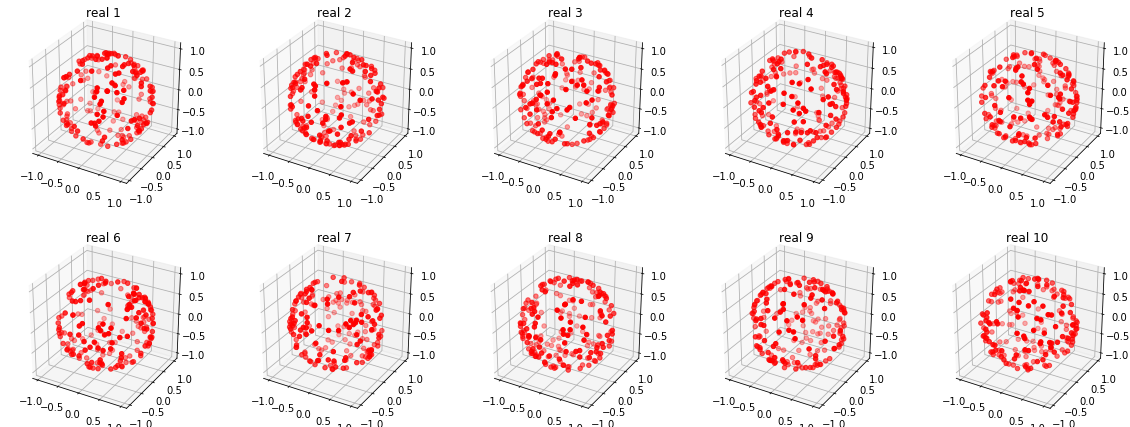

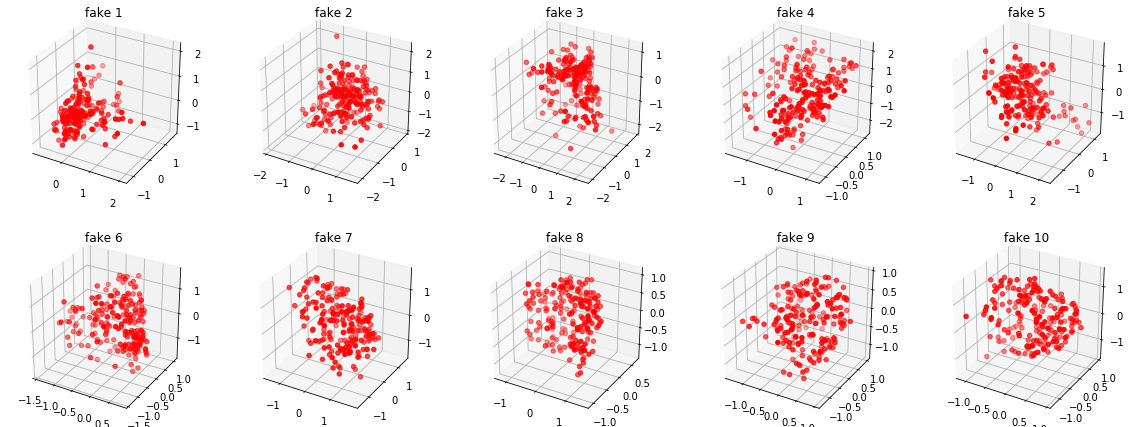

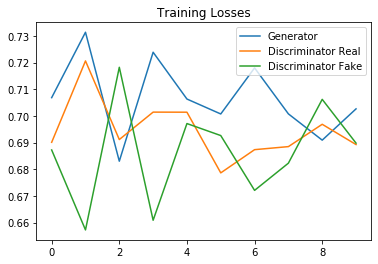

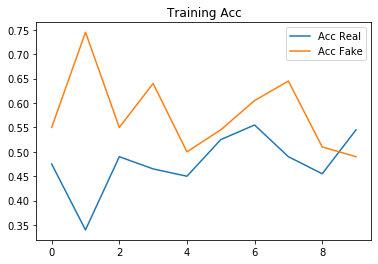

<Figure size 432x288 with 0 Axes>

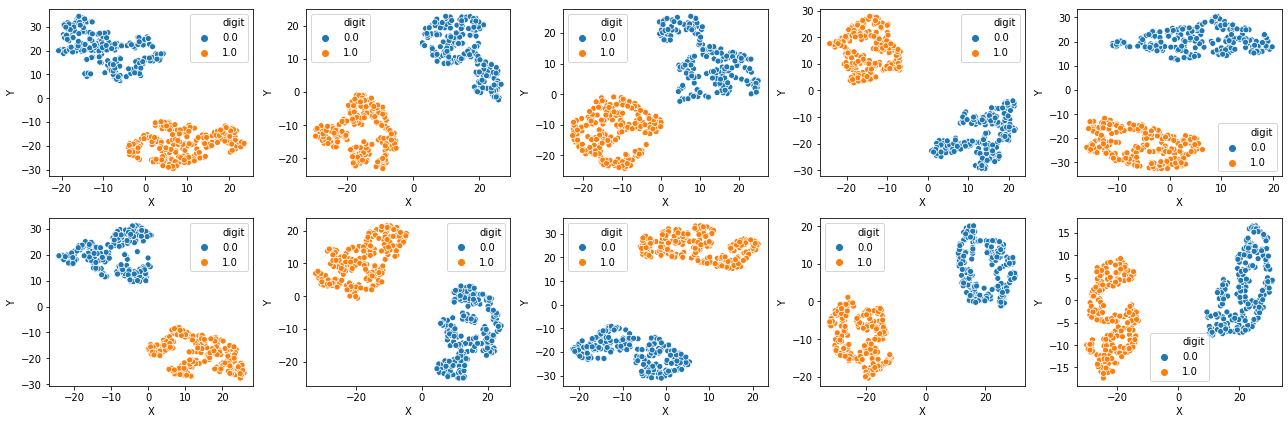

In [18]:
import keras 

def define_generator(latent_dim):
  model = Sequential()
  init = RandomNormal(mean=0.0, stddev=1.0)
  lrel = LeakyReLU(alpha=0.3)
  model.add(Dense(25, activation=lrel, kernel_initializer='he_uniform', input_dim=latent_dim))
 
  model.add(Dense(3, activation=lrel))
  return model   

def sample_interval(a,b,n1,n2):
  return ((b - a) * np.random.sample(n1 * n2) + a  ).reshape(n1,n2)

def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  #x_input = randn(latent_dim * n)
  x_input =  sample_interval(-1,1,latent_dim , n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input 

def generate_real_samples(n):
  theta = 2*np.pi*np.random.rand(n)
  phi = np.arccos(2*np.random.rand(n)-1)
  x1 = np.cos(theta) * np.sin(phi)
  y1 = np.sin(theta) * np.sin(phi)
  z1 = np.cos(phi)
 
  #print("nnnn",n)
  #X = np.vstack((x1, y1,z1)).reshape(n, 3)
  X = np.hstack((x1.reshape(-1,1),y1.reshape(-1,1),z1.reshape(-1,1)))
  #print("shape",X.shape)  64x3
  # generate class labels
  y = ones((n, 1))
  #print("shape2",y.shape)
  return X, y
 
learning_rate = 0.001
test_optimizer = TestSession(learning_rate,"Adam ",keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False))

gg = gan_gen("x",generate_real_samples,generate_latent_points,15000,1500  ,l_dim,3,define_generator,test_optimizer.optimizer,input_dim=1024  )
ressphere = gg.create()
draw_tsns4( ressphere )



parameters n_epochs, n_eval, n_batch  15000 1500 1024
200/200 [==============================] - 0s 38us/step


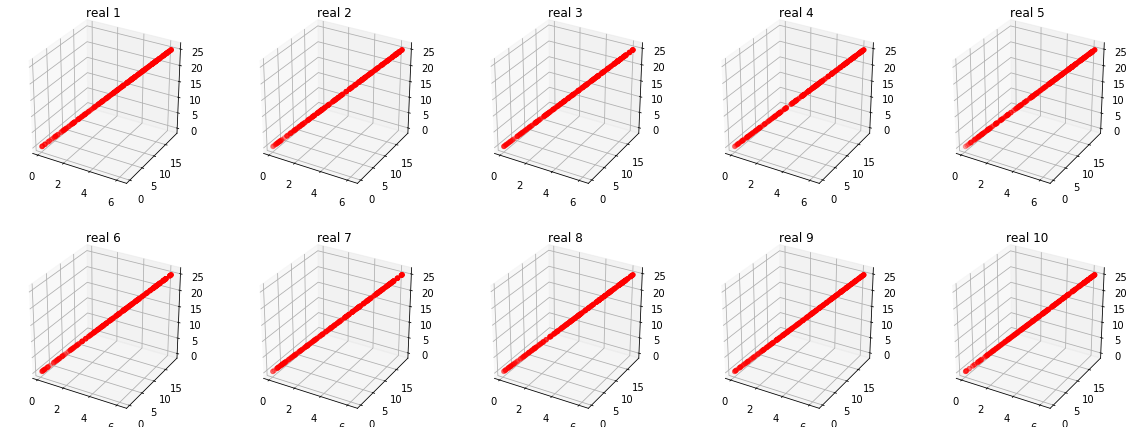

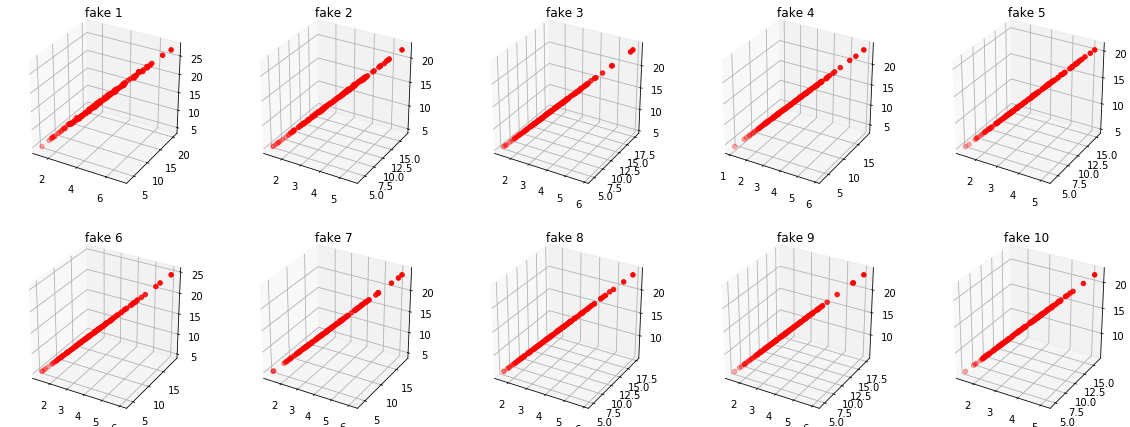

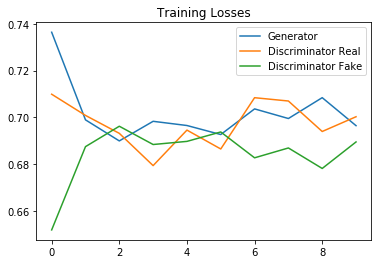

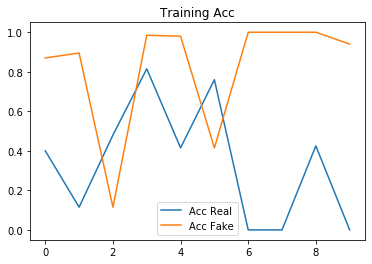

<Figure size 432x288 with 0 Axes>

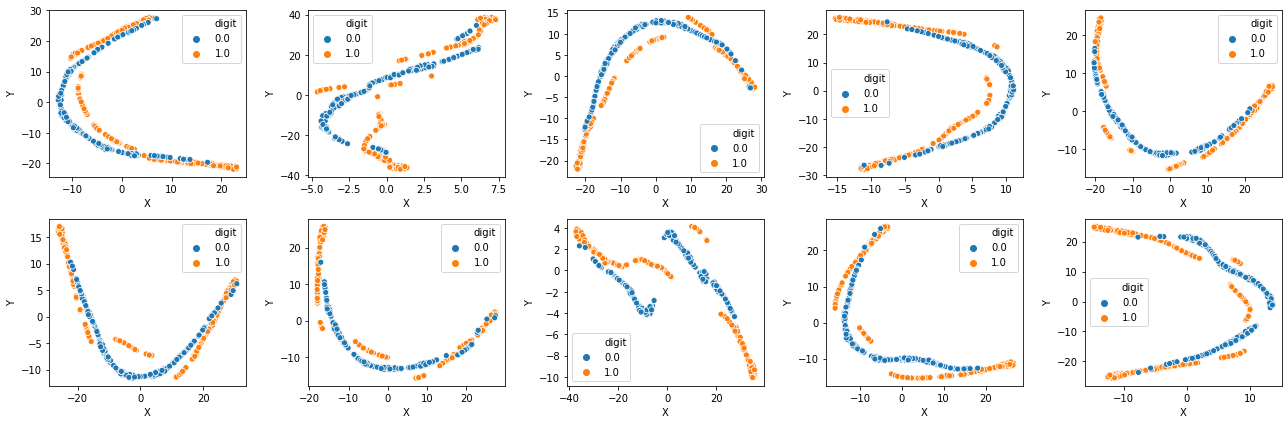

In [21]:
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  #x_input = randn(latent_dim * n)
  x_input = 2 * np.random.sample(latent_dim * n) - 1
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input      
    


def generate_real_samples(n):
  theta = 2*np.pi*np.random.rand(n)
  
  x1 = theta
  y1 = theta * 3
  z1 = x1 + y1 
  
  #print("nnnn",n)
  #X = np.vstack((x1, y1,z1)).reshape(n, 3)
  X = np.hstack((x1.reshape(-1,1),y1.reshape(-1,1),z1.reshape(-1,1)))
  #print("shape",X.shape)  64x3
  # generate class labels
  y = ones((n, 1))
  #print("shape2",y.shape)
  return X, y


learning_rate = 0.001
test_optimizer = TestSession(learning_rate,"Adam ",keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False))

gg = gan_gen("x",generate_real_samples,generate_latent_points,15000,1500  ,l_dim,3,define_generator,test_optimizer.optimizer,input_dim=1024  )

from keras.initializers import RandomNormal
#gg = gan_gen("x",generate_real_samples,generate_latent_points,20000,2000  ,10,3  )
reslinear = gg.create()  
draw_tsns4( reslinear )

parameters n_epochs, n_eval, n_batch  15000 1500 1024
200/200 [==============================] - 0s 41us/step


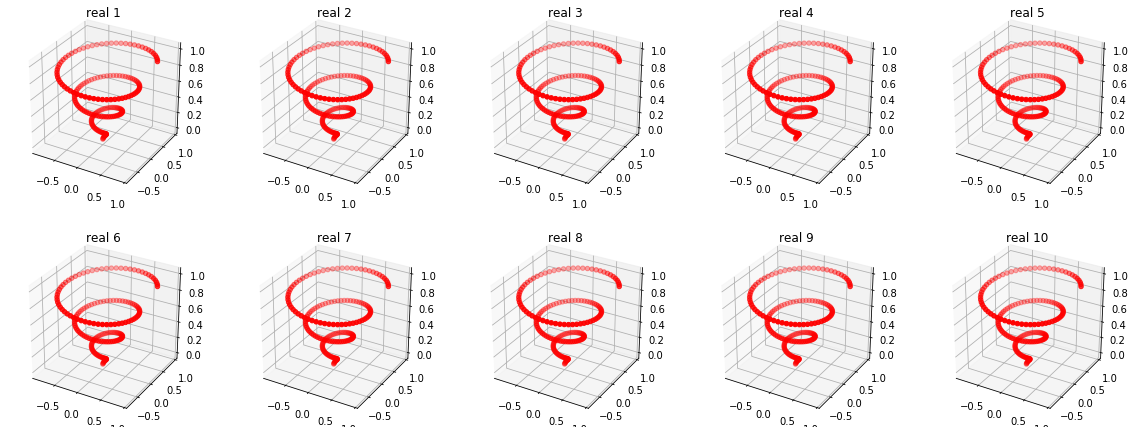

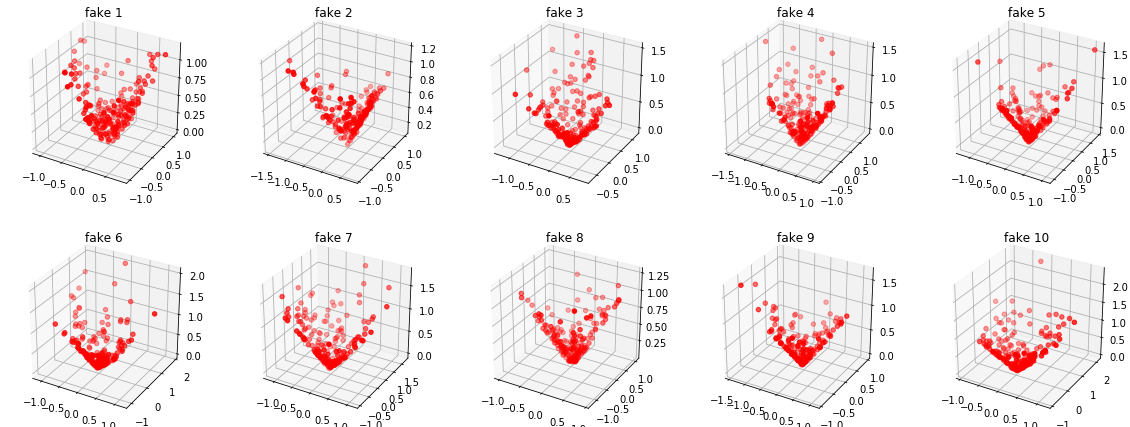

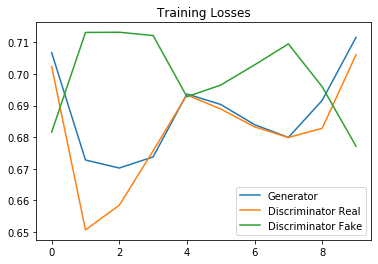

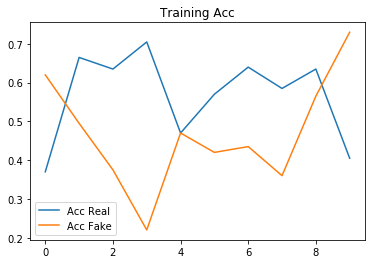

<Figure size 432x288 with 0 Axes>

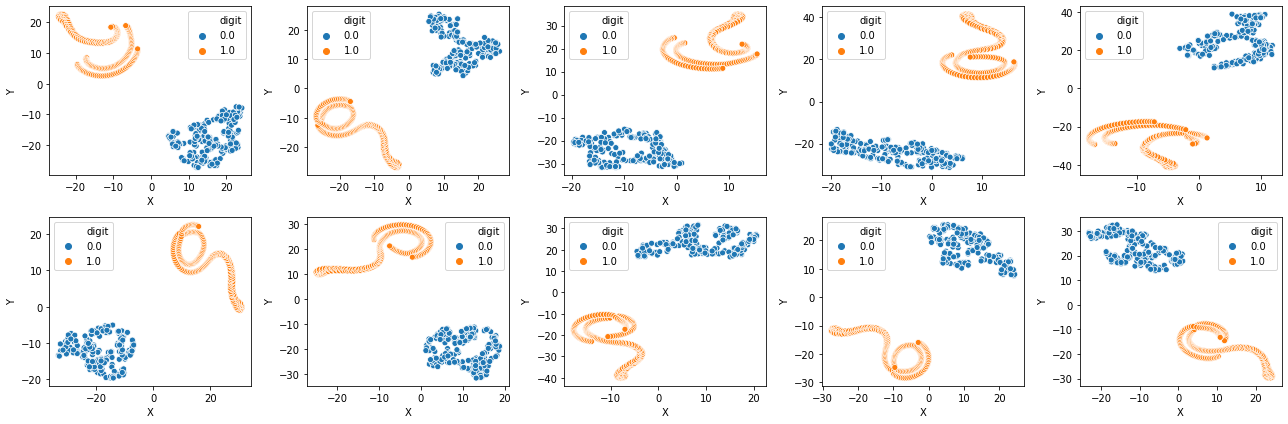

In [28]:
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  #x_input = randn(latent_dim * n)
  x_input = 2 * np.random.sample(latent_dim * n) - 1
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input      
    


def generate_real_samples(n):
  
  
  z1 = np.linspace(0, 1, n)
  x1 = z1 * np.sin(20 * z1)
  y1 = z1 * np.cos(20 * z1)
  
  #print("nnnn",n)
  #X = np.vstack((x1, y1,z1)).reshape(n, 3)
  X = np.hstack((x1.reshape(-1,1),y1.reshape(-1,1),z1.reshape(-1,1)))
  #print("shape",X.shape)  64x3
  # generate class labels
  y = ones((n, 1))
  #print("shape2",y.shape)
  return X, y

learning_rate = 0.001
test_optimizer = TestSession(learning_rate,"Adam ",keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False))

gg = gan_gen("x",generate_real_samples,generate_latent_points,15000,1500  ,l_dim,3,define_generator,test_optimizer.optimizer,input_dim=1024  )
ressphere = gg.create()
draw_tsns4( ressphere )  